# Parameter Identification Technique (PIT) on a linear VMM model in prime system

# Purpose
This is a follow up on [04.02_PIT_linear_VMM.ipynb](04.02_PIT_linear_VMM.ipynb) but now with parameters in prime system.
This means that:
* Model test results should be converted to prime system
* Added mass is estimated with brix.

# Methodology
* Load time series from a ZigZag test
* Convert to prime system.
* Calculate added masses with brix.

# Setup

In [119]:
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
from src.models import linear_vmm
import src.linear_vmm_equations as eq
import src.models.linear_vmm as model
from src.symbols import *
import src.symbols as symbols
from src import prime_system
from src.models import regression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load test

In [2]:
df_runs = mdl.runs()

In [3]:
#id=22773
#id=22616
#id=22774
id=22770


df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
df.index = df.index.total_seconds()
df = df.iloc[0:-100].copy()
df.index-=df.index[0]
df.sort_index(inplace=True)
df['V'] = np.sqrt(df['u']**2 + df['v']**2)

In [4]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
angle1                                                               10.0
angle2                                                               10.0
beam                                                             0.946602
comment                                                        ZZ 10/10PS
date                                                           2020-09-24
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\005\0...
gm                                    

In [5]:
df.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/Course,Wind/CourseTreshold,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0,x01d_gradient,y01d_gradient,z01d_gradient,z02d_gradient,psi1d_gradient,x0_filtered,x01d,x02d,y0_filtered,y01d,y02d,psi_filtered,psi1d,psi2d,u,v,w,u1d,v1d,w1d,r,r1d,beta,V
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,0.0,1.0,2.146755,0.000930,0.244419,0.0,-0.520477,10.131507,1.0,2.146755,-0.024623,0.122683,0.0,2.144633,11.329219,-0.000651,-0.009621,-0.007185,-0.002344,0.006963,0.008156,9.597722,5.567396,-0.113822,9.546612,5.328476,0.104278,-0.000007,0.645772,14.89,-0.005037,0.1,0.0,0.000025,0.000927,0.000325,-0.000873,7.611185,-0.001594,0.002499,1.020600,-0.003508,-0.022730,1.867924,0.017441,7.630116,0.932272,0.000005,-0.001617,0.000065,-6.810068e-07,-0.000821,0.000001,-0.000004,0.932272,0.000830,-0.022730,0.000005,-6.766628e-07,1.867924,0.000001,-0.000004,-0.000890,0.932272
0.010007,0.0,1.0,2.146755,0.000832,0.121932,0.0,-0.288911,10.131507,1.0,2.146755,-0.022034,0.126699,0.0,1.025401,11.329219,0.012245,-0.012845,-0.014928,-0.012007,0.019213,0.003000,9.572657,5.679435,-0.110951,9.558256,5.397689,0.106811,-0.000007,0.645772,14.89,-0.004507,0.1,0.0,0.000025,0.000972,-0.000254,-0.000698,7.621398,-0.001629,0.002271,0.508139,0.000864,-0.004038,1.308212,0.013081,7.625826,0.921355,-0.002257,-0.001613,0.000114,-1.514633e-05,-0.000735,-0.000025,-0.000024,0.921354,0.000791,-0.004038,-0.002257,-1.680414e-05,1.308212,-0.000025,-0.000024,-0.000859,0.921355
0.020011,0.0,1.0,2.146755,0.000736,-0.120384,0.0,0.000545,10.131507,1.0,2.146755,-0.019471,0.025530,0.0,1.913068,11.329219,-0.001296,-0.012200,-0.029125,0.002810,0.021792,0.002356,9.514150,5.728091,-0.107321,9.562515,5.484805,0.109010,0.000000,0.645772,14.89,-0.003983,0.1,0.0,0.000025,0.000915,0.000341,-0.000611,7.621356,-0.001577,0.002418,0.952405,0.001934,0.003452,0.258792,-0.008754,7.627892,0.921396,-0.003307,-0.001587,0.000145,-2.490043e-05,-0.000702,-0.000131,-0.000054,0.921396,0.000792,0.003452,-0.003307,-2.722338e-05,0.258792,-0.000131,-0.000054,-0.000860,0.921396
0.030001,0.0,1.0,2.146755,0.000638,-0.310377,0.0,0.521567,10.131507,1.0,2.146755,-0.016901,-0.089957,0.0,0.639459,11.329219,0.005152,-0.012845,-0.016219,-0.005565,0.007608,-0.001511,9.541821,5.700100,-0.104350,9.587783,5.548451,0.110168,0.000000,0.645772,14.89,-0.003457,0.1,0.0,0.000025,0.000945,-0.000327,-0.000873,7.640413,-0.001590,0.002341,1.483970,0.002393,0.001150,-0.262092,-0.008748,7.639433,0.923933,-0.002592,-0.001575,0.000151,-3.795793e-05,-0.000805,-0.000191,-0.000113,0.923932,0.000895,0.001150,-0.002592,-4.004497e-05,-0.262092,-0.000191,-0.000113,-0.000969,0.923933
0.040001,0.0,1.0,2.146755,0.000549,-0.303348,0.0,0.463676,10.131507,1.0,2.146755,-0.014543,-0.130523,0.0,-0.749933,11.329219,0.007087,-0.017357,-0.023318,-0.001700,0.017924,-0.002155,9.514368,5.613694,-0.103258,9.562679,5.586684,0.110073,0.000000,0.645772,14.89,-0.002975,0.1,0.0,0.000025,0.000929,0.000426,-0.000785,7.651012,-0.001529,0.002441,0.931076,0.003854,-0.001788,0.240757,-0.000002,7.649572,0.924786,-0.002156,-0.001540,0.000128,-4.577976e-05,-0.000809,-0.000182,-0.000150,0.924785,0.000876,-0.001788,-0.002156,-4.752416e-05,0.240757,-0.000182,-0.000150,-0.000948,0.924786


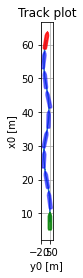

In [6]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

# Ship parameters

In [7]:
T_ = (meta_data.TA + meta_data.TF)/2
L_ = meta_data.lpp
m_ = meta_data.mass
rho_ = meta_data.rho
B_ = meta_data.beam
CB_ = m_/(T_*B_*L_*rho_)
I_z_ = m_*meta_data.KZZ**2

ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        'x_G' : 0,  # motions are expressed at CG
        'm' : m_,
        'I_z': I_z_, 
    }

ps = prime_system.PrimeSystem(**ship_parameters)  # model

scale_factor = meta_data.scale_factor
ps_ship = prime_system.PrimeSystem(L=ship_parameters['L']*scale_factor, rho=meta_data['rho'])  # ship

## Model test to prime system

In [8]:
interesting = [
    'u',
    'v',
    'r',
    'u1d',
    'v1d',
    'r1d',
    'delta',
    #'thrust',
]
df_prime = ps_ship.prime(df[interesting], U=df['V'])

In [9]:
df_prime.head()

,u,v,r,u1d,v1d,r1d,delta
time,,,,,,,
0.000000,1.0,0.000890,0.000241,0.001258,-0.000161,-0.220219,-0.000007
0.010007,1.0,0.000859,-0.005576,-0.549206,-0.004090,-1.210040,-0.000007
0.020011,1.0,0.000860,-0.029375,-0.804712,-0.006625,-2.724556,0.000000
0.030001,1.0,0.000969,-0.042616,-0.627420,-0.009692,-5.652799,0.000000
0.040001,1.0,0.000948,-0.040689,-0.520854,-0.011481,-7.503725,0.000000


# Linear VMM

## N

In [10]:
Math(vlatex(eq.N_eq))

<IPython.core.display.Math object>

In [11]:
N_eq = eq.N_eq.copy()
N_eq = N_eq.subs([
    (x_G,0),  # Assuming or moving to CG=0
    #(I_z,1),  # Removing inertia
    #(eq.p.Nrdot,0),  # Removing added mass
    (eq.p.Nvdot,0),  # Removing added mass
    (eq.p.Nudot,0),  # Removing added mass
    
])  

solution = sp.solve(N_eq,r.diff())[0]
N_eq = sp.Eq(r.diff(), solution*(I_z-eq.p.Nrdot))  # Putting r1d on the LHS

In [12]:
#Math(vlatex(N_eq))

In [13]:
diff_eq_N = regression.DiffEqToMatrix(ode=N_eq, label=r.diff(), base_features=[delta,u,v,r])

In [14]:
Math(vlatex(diff_eq_N.acceleration_equation))

<IPython.core.display.Math object>

$ y = X \cdot \beta + \epsilon $

In [15]:
Math(vlatex(diff_eq_N.acceleration_equation_x))

<IPython.core.display.Math object>

In [16]:
Math(vlatex(diff_eq_N.eq_y))

<IPython.core.display.Math object>

In [17]:
diff_eq_N.eq_beta

Eq(beta, Matrix([
[N_{\delta}],
[     N_{r}],
[     N_{u}],
[     N_{v}]]))

In [18]:
Math(vlatex(diff_eq_N.eq_X))

<IPython.core.display.Math object>

In [19]:
diff_eq_N.X_lambda

<function _lambdifygenerated(delta, r, u, v)>

In [20]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred(X,y,results, label):
    
    display(results.summary())
    
    X_ = X
    y_ = y
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    ax.plot(X_.index,y_, label='Numerical gradient from model test')
    ax.plot(X_.index,y_pred, '--', label='OLS')
    ax.set_ylabel(label)
    
    ax.fill_between(X_.index, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5\% confidence')
    ax.legend();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    r1d   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                          3.029e+04
Date:                Mon, 05 Jul 2021   Prob (F-statistic):                        0.00
Time:                        15:28:11   Log-Likelihood:                         -34184.
No. Observations:                5927   AIC:                                  6.838e+04
Df Residuals:                    5923   BIC:                                  6.840e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ndelta     -3303.7138     23.891   -138.285      0.000   -3350.548   -3256.879
Nr           -48.5062      1.046    -46.367      0.000     -50.557     -46.455
Nu             0.0943      1.043      0.090      0.928      -1.950       2.138
Nv          2391.4461     54.242     44.088      0.000    2285.111    2497.781
==============================================================================
Omnibus:                      320.038   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1272.539
Skew:                          -0.043   Prob(JB):                    4.70e-277
Kurtosis:                       5.268   Cond. No.                         378.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

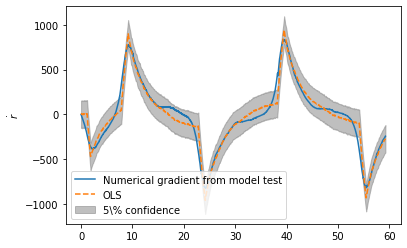

In [21]:
X = diff_eq_N.calculate_features(data=df_prime)
y = diff_eq_N.calculate_label(y=df_prime['r1d'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$\dot{r}$')

## Y

In [48]:
Y_eq = eq.Y_eq.copy()
Y_eq = Y_eq.subs([
    #(eq.p.Yvdot,1),  # Removing added mass
    (eq.p.Yudot,0),  # Removing added mass
    (eq.p.Yrdot,0),  # Removing added mass  
    (x_G,0),  
    
])  
solution = sp.solve(Y_eq,v.diff())[0]
solution = solution*(-eq.p.Yvdot+m)
solution = solution + U*m*r# (adding u*m*r to the measurement fy instead)  
solution = solution
Y_eq = sp.simplify(sp.Eq(v.diff(), solution))  # Putting r1d on the LHS

In [49]:
Math(vlatex(Y_eq))

<IPython.core.display.Math object>

In [50]:
diff_eq_Y = regression.DiffEqToMatrix(ode=Y_eq, label=v.diff(), base_features=[delta,u,v,r])

In [51]:
diff_eq_Y.eq_beta

Eq(beta, Matrix([
[Y_{\delta}],
[     Y_{r}],
[     Y_{u}],
[     Y_{v}]]))

In [52]:
diff_eq_Y.acceleration_equation_x

Eq(y, Y_{\delta}*x_1 + Y_{r}*x_2 + Y_{u}*x_3 + Y_{v}*x_4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    v1d   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.554e+06
Date:                Mon, 05 Jul 2021   Prob (F-statistic):                        0.00
Time:                        15:50:42   Log-Likelihood:                         -543.63
No. Observations:                5927   AIC:                                      1095.
Df Residuals:                    5923   BIC:                                      1122.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ydelta        12.0212      0.082    146.787      0.000      11.861      12.182
Yr             0.8345      0.004    232.707      0.000       0.827       0.842
Yu            -0.1417      0.004    -39.638      0.000      -0.149      -0.135
Yv           -64.9117      0.186   -349.101      0.000     -65.276     -64.547
==============================================================================
Omnibus:                        0.645   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.724   Jarque-Bera (JB):                0.645
Skew:                           0.026   Prob(JB):                        0.724
Kurtosis:                       2.998   Cond. No.                         378.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

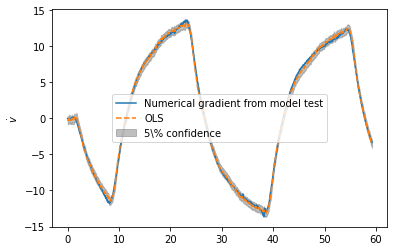

In [104]:
X = diff_eq_Y.calculate_features(data=df_prime, simplify_names=True)
y = diff_eq_Y.calculate_label(y=df_prime['v1d'])
m_prime = ps._prime(m_, unit='mass')
y+=df_prime['u']*m_prime*df_prime['r']/(m_prime-Yvdot_)  # subtracting centrifugal force

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$\dot{v}$')

In [105]:
X.head()

,Ydelta,Yr,Yu,Yv
time,,,,
0.000000,-0.000007,0.000241,1.0,0.000890
0.010007,-0.000007,-0.005576,1.0,0.000859
0.020011,0.000000,-0.029375,1.0,0.000860
0.030001,0.000000,-0.042616,1.0,0.000969
0.040001,0.000000,-0.040689,1.0,0.000948


## X

In [106]:
X_eq = eq.X_eq.copy()
X_eq = X_eq.subs([
    #(eq.p.Xudot,1),  # Removing added mass
    (eq.p.Xvdot,0),  # Removing added mass
    (eq.p.Xrdot,0),  # Removing added mass
    
    #(m,0),  # mass
    
])  

solution = sp.solve(X_eq,u.diff())[0]
X_eq = sp.Eq(u.diff(), solution*(-eq.p.Xudot+m))  # Putting r1d on the LHS

In [107]:
Math(vlatex(X_eq))

<IPython.core.display.Math object>

In [108]:
diff_eq_X = regression.DiffEqToMatrix(ode=X_eq, label=u.diff(), base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    u1d   R-squared (uncentered):                   0.258
Model:                            OLS   Adj. R-squared (uncentered):              0.258
Method:                 Least Squares   F-statistic:                              515.0
Date:                Mon, 05 Jul 2021   Prob (F-statistic):                        0.00
Time:                        15:50:58   Log-Likelihood:                         -1345.6
No. Observations:                5927   AIC:                                      2699.
Df Residuals:                    5923   BIC:                                      2726.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Xdelta         0.1121      0.094      1.196      0.232      -0.072       0.296
Xr            -0.0026      0.004     -0.624      0.532      -0.011       0.005
Xu             0.1622      0.004     39.643      0.000       0.154       0.170
Xv            -0.9987      0.213     -4.691      0.000      -1.416      -0.581
==============================================================================
Omnibus:                      150.172   Durbin-Watson:                   0.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              221.702
Skew:                           0.268   Prob(JB):                     7.21e-49
Kurtosis:                       3.782   Cond. No.                         378.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

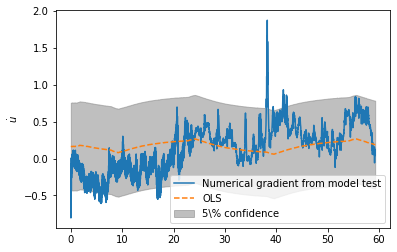

In [109]:
X = diff_eq_X.calculate_features(data=df_prime)
y = diff_eq_X.calculate_label(y=df_prime['u1d'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$\dot{u}$')

In [110]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

# Brix parameters

In [111]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)

mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'brix_prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)
df_parameters.loc['Ydelta','brix_prime'] = 0.005  # Just guessing
df_parameters.loc['Ndelta','brix_prime'] = -df_parameters.loc['Ydelta','brix_prime']/2  # Just guessing
df_parameters['brix_prime'].fillna(0, inplace=True)

In [141]:
Xudot_ = df_parameters.loc['Xudot','brix_prime']
Yvdot_ = df_parameters.loc['Yvdot','brix_prime']
Nrdot_ = df_parameters.loc['Nrdot','brix_prime']

I_z_prime = ps._prime(I_z_, unit='inertia_moment')

results_summary_X['value']  = results_summary_X['coeff']*(m_prime-Xudot_)/1000
results_summary_Y['value']  = results_summary_Y['coeff']*(m_prime-Yvdot_)/1000
results_summary_N['value']  = -results_summary_N['coeff']*(I_z_prime-Nrdot_)/1000



In [142]:
m_prime

0.006995127873817863

In [143]:
I_z_prime

0.00043719549211361644

## Add the regressed parameters
Hydrodynamic derivatives that depend on acceleration cannot be obtained from the VCT regression. They are however essential if a time simulation should be conducted. These values have then been taken from Brix semi empirical formulas for the simulations below.

In [144]:
df_parameters_all = df_parameters.copy()
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'value':'regressed'}, inplace=True)
df_parameters_all.drop(columns=['brix_lambda'], inplace=True)

df_parameters_all['prime'] = df_parameters_all['regressed'].combine_first(df_parameters_all['brix_prime'])  # prefer regressed

In [145]:
df_parameters_all

,$P_{value}$,$conf_{higher}$,$conf_{lower}$,brix,brix_prime,coeff,coord,dof,state,symbol,regressed,prime
Ndelta,0.000000e+00,-3256.879391,-3350.548187,NaN,-0.002500,-3303.713789,\delta,N,,N_{\delta},2.431105e-03,2.431105e-03
Ndeltadot,NaN,NaN,NaN,NaN,0.000000,NaN,\delta,N,dot,N_{\dot{\delta}},NaN,0.000000e+00
Nr,0.000000e+00,-46.455405,-50.556987,-pi*T**2*(0.039*B/T - 0.56*B/L + 0.25)/L**2,-0.001719,-48.506196,r,N,,N_{r},3.569427e-05,3.569427e-05
Nrdot,NaN,NaN,NaN,-pi*T**2*(0.017*B*CB/T - 0.33*B/L + 0.08333333...,-0.000299,NaN,r,N,dot,N_{\dot{r}},NaN,-2.986748e-04
Nu,9.279303e-01,2.138355,-1.949727,NaN,0.000000,0.094314,u,N,,N_{u},-6.940280e-08,-6.940280e-08
Nudot,NaN,NaN,NaN,NaN,0.000000,NaN,u,N,dot,N_{\dot{u}},NaN,0.000000e+00
Nv,0.000000e+00,2497.781092,2285.111174,-pi*T**2*(0.5 + 2.4*T/L)/L**2,-0.003184,2391.446133,v,N,,N_{v},-1.759794e-03,-1.759794e-03
Nvdot,NaN,NaN,NaN,-pi*T**2*(-0.04*B/T + 1.1*B/L)/L**2,-0.000128,NaN,v,N,dot,N_{\dot{v}},NaN,-1.282544e-04
Xdelta,2.317182e-01,0.295950,-0.071661,NaN,0.000000,0.112145,\delta,X,,X_{\delta},7.844654e-07,7.844654e-07
Xdeltadot,NaN,NaN,NaN,NaN,0.000000,NaN,\delta,X,dot,X_{\dot{\delta}},NaN,0.000000e+00


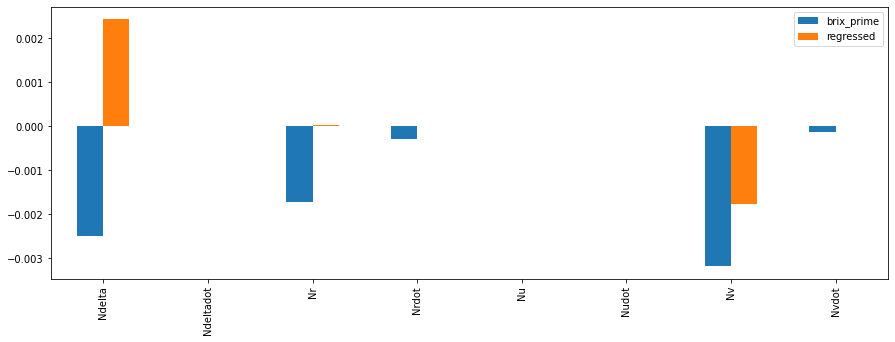

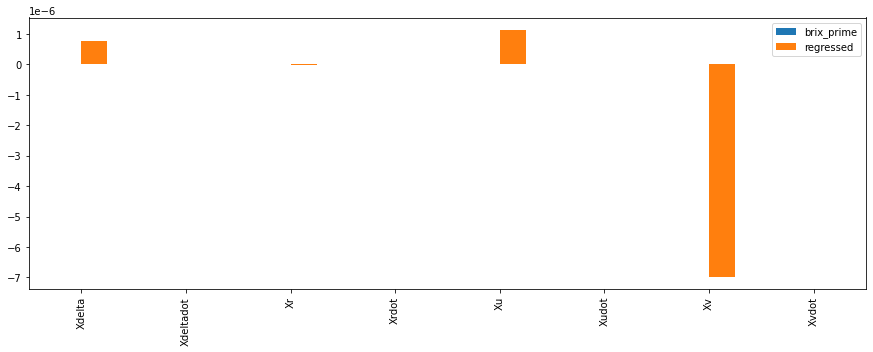

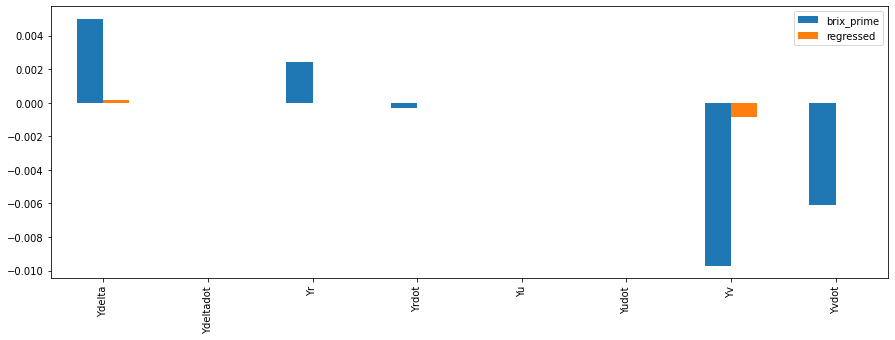

In [146]:
for dof, group in df_parameters_all.groupby(by='dof'):
    
    fig,ax=plt.subplots()
    fig.set_size_inches(15,5)

    group.plot.bar(y=['brix_prime','regressed'], ax=ax);

# Simulation

<AxesSubplot:xlabel='time'>

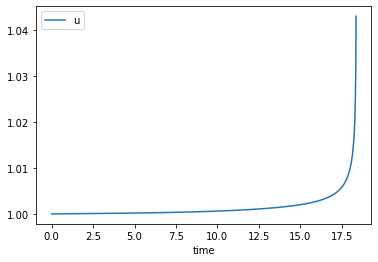

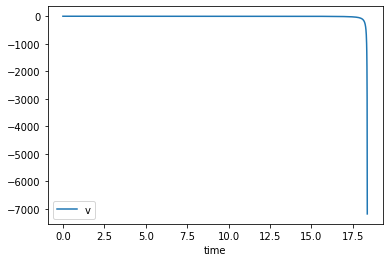

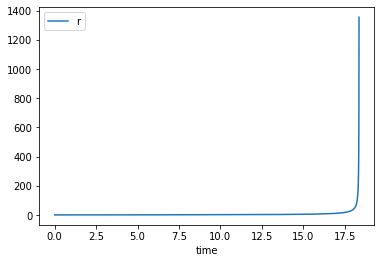

In [147]:
df_ = df.copy()
t = df_.index
control = df_[['delta']]
#control = {'delta':0,}

df_0 = df_.iloc[0:100].median(axis=0)
y0 = {
    'u' : df_0['u'], 
    'v' : df_0['v'],
    'r' : df_0['r'],
    'x0' : df_0['x0'],
    'y0' : df_0['y0'],
    'psi' : df_0['psi'],
    }

#solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters, df_ship_parameters=df_ship_parameters, control=control, rtol=1e-3, atol=1e-3)
solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters_all, ship_parameters=ship_parameters, control=control)

columns = list(y0.keys())
df_result_prime = pd.DataFrame(data=solution.y.T, columns=columns)
df_result_prime.index=t[0:len(df_result_prime)]

#df_result_prime['U'] = np.sqrt(df_result_prime['u']**2 + df_result_prime['v']**2)

df_result_prime.plot(y='u')
df_result_prime.plot(y='v')
df_result_prime.plot(y='r')


In [148]:
U_ = np.sqrt(df_0['u']**2 + df_0['v']**2)
df_result = ps.unprime(values=df_result_prime, U=U_)
df_result['beta'] = -np.arctan2(df_result['v'],df_result['u'])

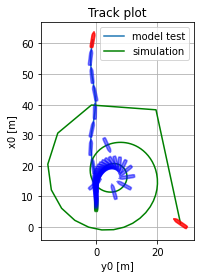

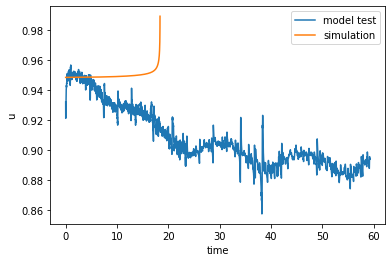

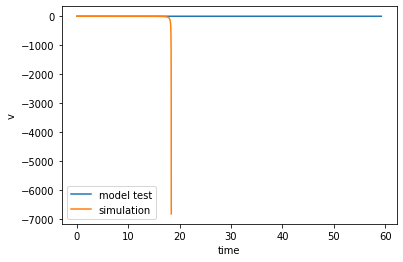

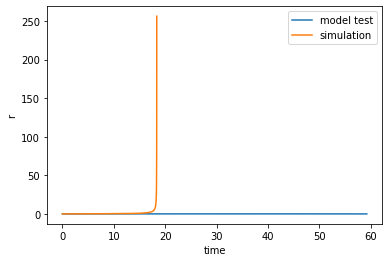

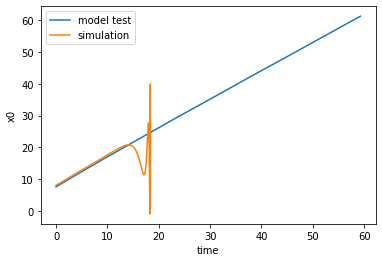

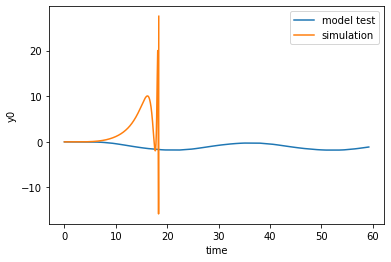

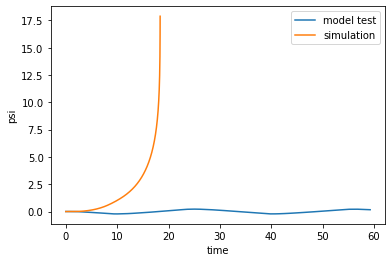

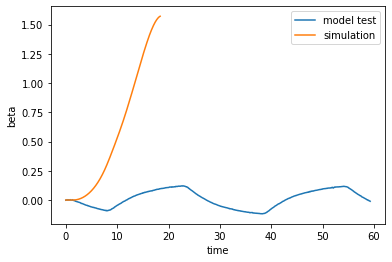

In [149]:
fig,ax=plt.subplots()
track_plot(df=df, lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='model test')
track_plot(df=df_result, lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='simulation', color='green')
ax.legend()


for key in df_result:
    fig,ax = plt.subplots()
    df.plot(y=key, label='model test', ax=ax)
    df_result.plot(y=key, label='simulation', ax=ax)
    ax.set_ylabel(key)



In [41]:
eqs = [diff_eq_X.acceleration_equation, diff_eq_Y.acceleration_equation, diff_eq_N.acceleration_equation]
solution = sp.solve(eqs, u.diff(), v.diff(), r.diff(), dict=True)

## Decouple the equations:
u1d_eq = sp.Eq(u.diff(), solution[0][u.diff()]) 
v1d_eq = sp.Eq(v.diff(), solution[0][v.diff()]) 
r1d_eq = sp.Eq(r.diff(), solution[0][r.diff()]) 

## Lambdify:
subs = {value:key for key,value in eq.p.items()}
u1d_lambda = lambdify(u1d_eq.subs(subs).rhs)
v1d_lambda = lambdify(v1d_eq.subs(subs).rhs)
r1d_lambda = lambdify(r1d_eq.subs(subs).rhs)

In [42]:
display(Math(vlatex(u1d_eq)))
display(Math(vlatex(v1d_eq)))
display(Math(vlatex(r1d_eq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [43]:
from scipy.spatial.transform import Rotation as R

def step(t, states, parameters, df_control, meta_data):
    
    u,v,r,x0,y0,psi = states

    states_dict = {
        
        'u':u,
        'v':v,
        'r':r,
        
        'x0':x0,
        'y0':y0,
        'psi':psi,
        
        }
        
    inputs = dict(parameters)
    inputs.update(states_dict)
    
    index = np.argmin(np.array(np.abs(df_control.index - t)))
    control = dict(df_control.iloc[index])
    #print(f't:{t}, i:{index}')
    inputs.update(control)
    
    inputs['U'] = np.sqrt(u**2 + v**2)  #Instantanious velocity
    
    if not 'u1d' in control:
        u1d = -run(function=u1d_lambda, inputs=inputs)
    else:
        u1d = control['u1d']
    
    mass = meta_data['mass']
    v1d = run(function=v1d_lambda, inputs=inputs) - u*r
    #v1d = run(function=v1d_lambda, inputs=inputs)
    
    r1d = run(function=r1d_lambda, inputs=inputs)
    
    
    rotation = R.from_euler('z', psi, degrees=False)
    w = 0
    velocities = rotation.apply([u,v,w])
    x01d = velocities[0]
    y01d = velocities[1]
    psi1d = r    

    dstates = [
        u1d,
        v1d,
        r1d,
        x01d,
        y01d,
        psi1d,
    ]    
    
    #print(t)
    
    return dstates



In [44]:
parameters = dict(results_summary_X['coeff'])  # Fix (-)
parameters.update(dict(results_summary_Y['coeff']))   # Fix (-)
parameters.update(dict(results_summary_N['coeff']))

states = ['u','v','r','x0','y0','psi']
states0 = [float(df[key].iloc[0]) for key in states]
#df_control = df[['delta','u1d','u']]
df_control = df[['delta']].copy()
#df_control['delta']+=np.deg2rad(0.5)

In [45]:
t_ = 10
index = np.argmin(np.array(np.abs(df_control.index - t_)))
df_control.iloc[index]

delta   -0.174529
Name: 10.000023000000002, dtype: float64

In [46]:
(np.diff(df_control.index) > 0).all()

True

In [47]:
## Simulate:
df_ = df.copy()
t = np.array(df_.index)
t_span = [t[0],t[-1]]
solution = solve_ivp(fun=step, t_span=t_span, y0=states0, t_eval=t, args=(parameters, df_control, meta_data), method='RK45')

ValueError: Sympy lambda function misses:['m', 'Yr']

In [ ]:
df_result = pd.DataFrame(data=solution.y.T, columns=states)
df_result.index=t

In [ ]:
fig,ax=plt.subplots()
#fig.set_size_inches(15,15)
track_plot(df=df_, lpp=meta_data['lpp'], beam=meta_data['beam'], ax=ax, color='k', label='model test');
track_plot(df=df_result, lpp=meta_data['lpp'], beam=meta_data['beam'], ax=ax, color='g', label='simulation');
ax.legend()

In [ ]:
fig,ax=plt.subplots()
df_['-delta'] = -df_['delta']
df_.plot(y='-delta', style='--', ax=ax)
df_.plot(y='psi', ax=ax, label='model test')
df_result.plot(y='psi', ax=ax, label='simulation')
ax.legend()


for key in ['u','v','r']:
    
    fig,ax=plt.subplots()
    df_.plot(y=key, ax=ax, label='model test')
    df_result.plot(y=key, ax=ax, label='simulation')
    ax.set_ylabel(key)
